### Environment setup

In [15]:
import boto3
import numpy as np
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

sm_boto3 = boto3.client("sagemaker")

sess = sagemaker.Session()

region = sess.boto_session.region_name

BUCKET_URI = "s3://dry-bean-bucket"
BUCKET_NAME = "dry-bean-bucket"

print("Using bucket " + BUCKET_NAME)

Using bucket dry-bean-bucket


In [16]:
DATASET_PATH = BUCKET_URI + "/dry_bean.csv"
TARGET_NAME = "Class"

dry_bean = pd.read_csv(DATASET_PATH)

dry_bean.head()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272750,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [17]:
from sklearn.preprocessing import LabelEncoder

# For preprocessing
df = dry_bean.copy(deep=True)

# Encode the target
le = LabelEncoder()
df[TARGET_NAME] = le.fit_transform(df[TARGET_NAME])

In [18]:
from sklearn.model_selection import train_test_split

# Split the data into two sets
train, test = train_test_split(df, random_state=1, test_size=0.2)

In [22]:
train.to_csv("dry-bean-train.csv")
test.to_csv("dry-bean-test.csv")

In [23]:
# send data to S3. SageMaker will take training data from s3
trainpath = sess.upload_data(
    path="dry-bean-train.csv",
    bucket=BUCKET_NAME,
    key_prefix="sagemaker/sklearncontainer",
)

testpath = sess.upload_data(
    path="dry-bean-test.csv",
    bucket=BUCKET_NAME,
    key_prefix="sagemaker/sklearncontainer",
)

In [24]:
from sklearn.metrics import balanced_accuracy_score

In [26]:
%%writefile script.py

import argparse
import os

import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score

if __name__ == "__main__":
    print("extracting arguments")
    parser = argparse.ArgumentParser()

    # hyperparameters sent by the client are passed as command-line arguments to the script.
    parser.add_argument("--n-estimators", type=int, default=10)
    parser.add_argument("--min-samples-leaf", type=int, default=3)

    # Data, model, and output directories
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--test", type=str, default=os.environ.get("SM_CHANNEL_TEST"))
    parser.add_argument("--train-file", type=str, default="dry-bean-train.csv")
    parser.add_argument("--test-file", type=str, default="dry-bean-test.csv")

    args, _ = parser.parse_known_args()

    print("reading data")
    train_df = pd.read_csv(os.path.join(args.train, args.train_file))
    test_df = pd.read_csv(os.path.join(args.test, args.test_file))

    print("building training and testing datasets")
    X_train = train_df.drop("Class", axis=1)
    X_test = test_df.drop("Class", axis=1)
    y_train = train_df[["Class"]]
    y_test = test_df[["Class"]]

    # train
    print("training model")
    model = RandomForestClassifier(
        n_estimators=args.n_estimators,
        min_samples_leaf=args.min_samples_leaf,
        n_jobs=-1,
    )

    model.fit(X_train, y_train)

    # print balanced accuracy
    print("validating model")
    bal_acc_train = balanced_accuracy_score(y_train, model.predict(X_train))
    bal_acc_test = balanced_accuracy_score(y_test, model.predict(X_test))

    print(f"Train balanced accuracy: {bal_acc_train:.3f}")
    print(f"Test balanced accuracy: {bal_acc_test:.3f}")

    # persist model
    path = os.path.join(args.model_dir, "model.joblib")
    joblib.dump(model, path)
    print("model persisted at " + path)
    print(args.min_samples_leaf)

Overwriting script.py


In [28]:
! python script.py --n-estimators 100 \
                   --min-samples-leaf 2 \
                   --model-dir ./ \
                   --train ./ \
                   --test ./ \

extracting arguments
reading data
building training and testing datasets
training model
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
validating model
Train balanced accuracy: 1.000
Test balanced accuracy: 0.998
model persisted at ./model.joblib
2


In [33]:
# We use the Estimator from the SageMaker Python SDK
from sagemaker.sklearn.estimator import SKLearn

FRAMEWORK_VERSION = "0.23-1"

sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 3,
    },
)

In [34]:
# launch training job, with asynchronous call
sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

INFO:sagemaker:Creating training-job with name: rf-scikit-2024-06-04-10-36-31-142


2024-06-04 10:36:31 Starting - Starting the training job...
2024-06-04 10:36:46 Starting - Preparing the instances for training...
2024-06-04 10:37:13 Downloading - Downloading input data...
2024-06-04 10:37:53 Training - Training image download completed. Training in progress..2024-06-04 10:37:57,878 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-06-04 10:37:57,881 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-04 10:37:57,922 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-06-04 10:37:58,085 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-04 10:37:58,096 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-04 10:37:58,107 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-04 10:37:58,115 sagemaker-training-toolkit INFO     Invoking user script
T

### SPOT

In [35]:
spot_sklearn_estimator = SKLearn(
    entry_point="script.py",
    role=get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version=FRAMEWORK_VERSION,
    base_job_name="rf-scikit",
    hyperparameters={
        "n-estimators": 100,
        "min-samples-leaf": 3,
    },
    use_spot_instances=True,
    max_wait=7200,
    max_run=3600,
)

In [36]:
# launch training job, with asynchronous call
spot_sklearn_estimator.fit({"train": trainpath, "test": testpath}, wait=True)

INFO:sagemaker:Creating training-job with name: rf-scikit-2024-06-04-10-43-40-312


2024-06-04 10:43:40 Starting - Starting the training job...
2024-06-04 10:43:56 Starting - Preparing the instances for training...
2024-06-04 10:44:23 Downloading - Downloading input data...
2024-06-04 10:45:09 Training - Training image download completed. Training in progress..2024-06-04 10:45:13,695 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2024-06-04 10:45:13,702 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-04 10:45:13,778 sagemaker_sklearn_container.training INFO     Invoking user training script.
2024-06-04 10:45:14,030 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-04 10:45:14,047 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-04 10:45:14,063 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-06-04 10:45:14,073 sagemaker-training-toolkit INFO     Invoking user script
T

In [39]:
# we use the Hyperparameter Tuner
from sagemaker.tuner import IntegerParameter

# Define exploration boundaries
hyperparameter_ranges = {
    "n-estimators": IntegerParameter(20, 100),
    "min-samples-leaf": IntegerParameter(2, 6),
}

# create Optimizer
Optimizer = sagemaker.tuner.HyperparameterTuner(
    estimator=sklearn_estimator,
    hyperparameter_ranges=hyperparameter_ranges,
    base_tuning_job_name="RF-tuner",
    objective_type="Maximize",
    objective_metric_name="balanced-accuracy",
    metric_definitions=[
        {"Name": "balanced-accuracy", "Regex": "Test balanced accuracy: ([0-9.]+).*$"}
    ],  # extract tracked metric from logs with regexp
    max_jobs=10,
    max_parallel_jobs=2,
)

In [40]:
Optimizer.fit({"train": trainpath, "test": testpath})

INFO:sagemaker:Creating hyperparameter tuning job with name: RF-tuner-240604-1049


.........................................................!


In [41]:
# get tuner results in a df
results = Optimizer.analytics().dataframe()

while results.empty:
    time.sleep(1)
    results = Optimizer.analytics().dataframe()

results.head()

,min-samples-leaf,n-estimators,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,3.0,68.0,RF-tuner-240604-1049-010-27508f8b,Completed,0.997,2024-06-04 10:53:46+00:00,2024-06-04 10:54:14+00:00,28.0
1,2.0,77.0,RF-tuner-240604-1049-009-38d75f35,Completed,0.999,2024-06-04 10:53:44+00:00,2024-06-04 10:54:13+00:00,29.0
2,4.0,67.0,RF-tuner-240604-1049-008-15d95e7d,Completed,0.997,2024-06-04 10:53:02+00:00,2024-06-04 10:53:31+00:00,29.0
3,3.0,28.0,RF-tuner-240604-1049-007-098acdd6,Completed,0.998,2024-06-04 10:53:01+00:00,2024-06-04 10:53:31+00:00,30.0
4,5.0,26.0,RF-tuner-240604-1049-006-5cb40190,Completed,0.998,2024-06-04 10:52:19+00:00,2024-06-04 10:52:50+00:00,31.0


In [44]:
best_model = Optimizer.best_estimator()


2024-06-04 10:54:17 Starting - Found matching resource for reuse
2024-06-04 10:54:17 Downloading - Downloading the training image
2024-06-04 10:54:17 Training - Training image download completed. Training in progress.
2024-06-04 10:54:17 Uploading - Uploading generated training model
2024-06-04 10:54:17 Completed - Resource retained for reuse


In [53]:
artifact = sm_boto3.describe_training_job(
    TrainingJobName=best_model.latest_training_job.name
)["ModelArtifacts"]["S3ModelArtifacts"]

print("Model artifact persisted at " + artifact)

Model artifact persisted at s3://sagemaker-us-east-1-496320894061/RF-tuner-240604-1049-009-38d75f35/output/model.tar.gz


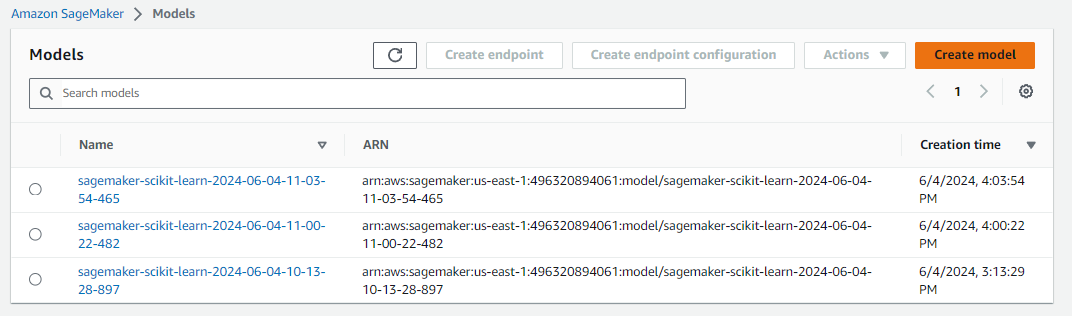

In [54]:
from sagemaker.sklearn.model import SKLearnModel

model = SKLearnModel(
    model_data=artifact,
    role=get_execution_role(),
    entry_point="script.py",
    framework_version=FRAMEWORK_VERSION,
)

In [56]:
predictor = model.deploy(instance_type="ml.c5.large", initial_instance_count=1)

INFO:sagemaker:Creating model with name: sagemaker-scikit-learn-2024-06-04-11-03-54-465
INFO:sagemaker:Creating endpoint-config with name sagemaker-scikit-learn-2024-06-04-11-03-54-960
INFO:sagemaker:Creating endpoint with name sagemaker-scikit-learn-2024-06-04-11-03-54-960


-----!

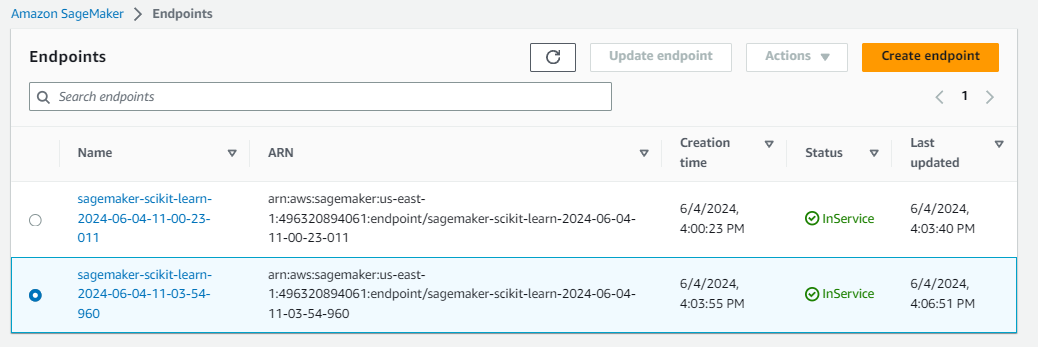

In [76]:
# the SKLearnPredictor does the serialization from pandas for us
preds = predictor.predict(test.sample(4))

In [77]:
preds

array([3, 3, 3, 3])

In [ ]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint)